<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05%20Deep%20Learning/notebooks/10-Embeddings-graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Graph Embeddings</h1>

En esta notebook demostraremos brevemente como obtener embeddings de diversos elementos de un grafo, en este caso concreto, los vértices. Para esto usaremos la red `node2vec`. 

Esta red funciona en base al mismo principio que `word2vec`: analiza secuencias (documentos) de nodos (tokens) y busca las co-ocurrencias para predecir nodos dado el contexto (o viceversa). Las secuencias de nodos son producidas por caminatas aleatorias en el grafo. 

Al igual que word2vec, esta red captura las *co-ocurrencias* de segundo orden entre nodos. 

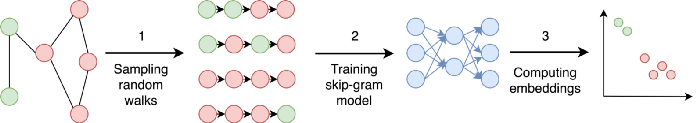

Este dataset del módulo networkx es contiene información de los miembros de un club de karate universitario. El grafo representa la presencia o ausencia de lazos entre los miembros del club. Los pesos de las aristas indican la fuerza del lazo entre miembros (el número de situaciones dentro y fuera del club en las cuales las interacciones occurren).

Estos datos primero se usaron para explicar la ruptura de este grupo como consecuencia de las disuputas entre miembros. 

[Link](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm#zachary) del dataset.

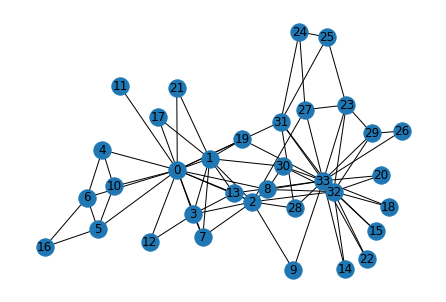

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()

pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)
plt.show()

## Entrenamos el modelo `Node2Vec` 

In [ ]:
!pip install -q Node2Vec

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=50, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
n2v = node2vec.fit(window=10, min_count=1, batch_words=4)

## Exploremos el modelo

Veamos el vector de un nodo

In [ ]:
n2v.wv.get_vector('0')

array([-0.24297306,  0.12498032, -0.02080512, -0.11682868,  0.18303229,
        0.18828662,  0.06194494,  0.03130161, -0.12913729, -0.06235697,
        0.23985748,  0.14563242, -0.05139523, -0.2235139 ,  0.1183093 ,
        0.09274844, -0.17925113, -0.10166655,  0.07882518,  0.04191436,
        0.13088746, -0.29545933, -0.1634639 , -0.16145536, -0.06935246,
       -0.05988537,  0.05500449, -0.06803206,  0.04848628,  0.17819747,
       -0.10409588,  0.01619227, -0.1561937 ,  0.11015041, -0.02945336,
       -0.06654796,  0.04969713, -0.04501005,  0.22052954, -0.05999541,
        0.06135996, -0.10144451,  0.05085875,  0.03608773,  0.15275092,
       -0.2570891 , -0.10646545,  0.17650777,  0.2526472 ,  0.05927813,
       -0.22873539,  0.05810612, -0.04714724, -0.15742071,  0.01905322,
        0.01124712,  0.12356723,  0.21260662, -0.29506654,  0.06845451,
        0.03365501, -0.18316548, -0.13439173, -0.00599198], dtype=float32)

Podemos obtener los nodos más similares a un nodo dado, observar en la gráfica que estos están relacionados con los vecinos del nodo. Estas similitudes están dadas en el término de co-ocurrencias en caminatas aleatorias.

In [ ]:
n2v.wv.most_similar('0')

[('11', 0.7363128662109375),
 ('10', 0.7299283742904663),
 ('4', 0.7258478999137878),
 ('21', 0.7162420749664307),
 ('13', 0.7128410339355469),
 ('5', 0.7048994302749634),
 ('17', 0.7029905915260315),
 ('19', 0.7011687755584717),
 ('6', 0.6840389966964722),
 ('7', 0.6814824342727661)]

## Clustering

Dado que ahora cada nodo está representado por un vector de 64 coordenadas. Podemos realizar cualquier tarea de Machine Learning sobre los nodos. En este caso, realizaremos el clustering.

In [ ]:
X = n2v.wv.vectors
X.shape

(34, 64)

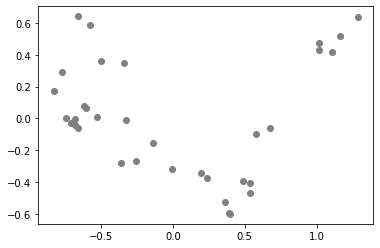

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],color='gray')
plt.show()

Ahora, clusterizemos los embeddings

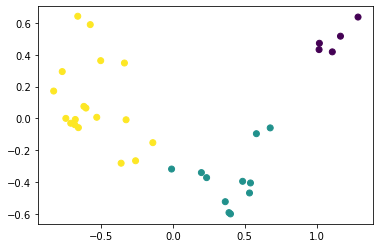

In [ ]:
from sklearn.cluster import KMeans

k = 3

kmeans = KMeans(n_clusters=k)
kmeans.fit_predict(X)
embedding_clusters = kmeans.labels_

plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],c=embedding_clusters)
plt.show()

El siguiente diccionario nos dice cada índice a qué nodo corresponde

In [ ]:
index_to_word_dict = dict(zip(list(range(X.shape[0])),n2v.wv.index2word))
index_to_word_dict

{0: '33',
 1: '0',
 2: '32',
 3: '2',
 4: '1',
 5: '3',
 6: '31',
 7: '13',
 8: '23',
 9: '8',
 10: '6',
 11: '5',
 12: '29',
 13: '30',
 14: '7',
 15: '27',
 16: '4',
 17: '10',
 18: '25',
 19: '28',
 20: '24',
 21: '19',
 22: '17',
 23: '16',
 24: '22',
 25: '12',
 26: '21',
 27: '20',
 28: '14',
 29: '26',
 30: '9',
 31: '18',
 32: '15',
 33: '11'}

Recuperamos la clusterización que habíamos hecho de este grafo

In [ ]:
import scipy as sp
import random
import numpy as np

def get_k_colors(k=3):
    return [(np.cos(np.pi*j/(k*2)),random.uniform(0, 1),j/k) for j in range(k)]

L = nx.laplacian_matrix(G).astype(float)
eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L, k = 3, which='SM')
X = eigenvectors*eigenvalues

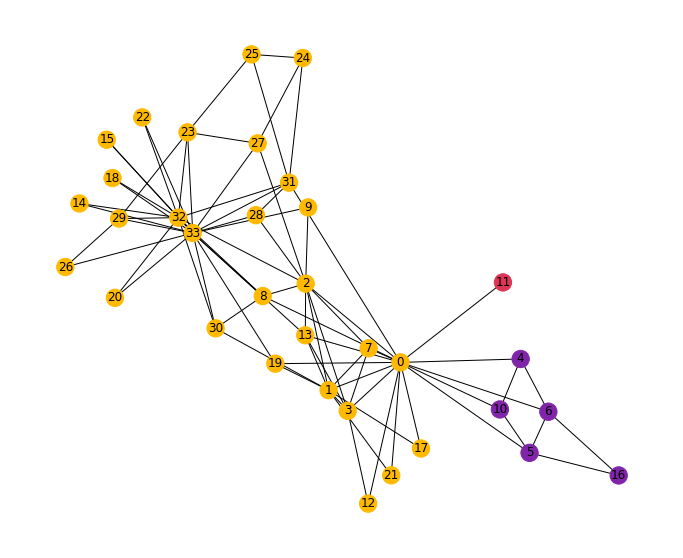

In [ ]:
from sklearn.cluster import KMeans

k = 3
clusters_colors = get_k_colors(k)

model = KMeans(init='k-means++', n_clusters=k, n_init=10)
model.fit_predict(X)
node_clusters = model.labels_

fig = plt.subplots(1, figsize=(12,10))
node_colors = [clusters_colors[node_clusters[v]] for v in G.nodes()]
nx.draw(G, node_color=node_colors, with_labels='True')

Comparamos ambos clusterings

In [ ]:
print("Clusters del grafo:")
print(node_clusters)

Clusters del grafo:
[0 0 0 0 2 2 2 0 0 0 2 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print("Clusters de los embeddings:")

translated_clusters = X.shape[0]*[0]

for j in range(X.shape[0]):
    t_idx = int(index_to_word_dict[j])
    translated_clusters[t_idx] = embedding_clusters[j]

print(translated_clusters)

Clusters de los embeddings:
[1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


También podemos comparar los clusters usando el AMI entre ambos clusterings.

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score

adjusted_mutual_info_score(node_clusters,translated_clusters)

0.5455662398552654